# Machine learning for medicine (MedML@Emory) Workshop
## Intermediate Linear Regression: The gateway to machine learning
Authors: Vineet Tiruvadi, Avinash Murugan, Alex Milani

## License
    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

## Overview
Linear regression is the workhorse of science.
Linear regression translates to "can we fit a line that tells us how our variables relate to each other"?

<!-- ![](https://upload.wikimedia.org/wikipedia/commons/3/3a/Linear_regression.svg) -->
![](https://vineet.tiruvadi.com/Figure_1.png)


For example, this could be the relationship between how long we cook an egg (x-axis on horizontal) and how delicious it is (y-axis on vertical).
It makes sense: not very delicious when we cook for 0 minutes, very delicious when we cook for 10 minutes.

Of course, there's a limit where it *isn't* linear anymore.
A lot of the exciting things in ML relate to *nonlinear* relationships and being able to "regress" them.
This is an important point that we'll return to later.

This notebook will be focused on some basic ML approaches to linear regression in high dimensional datasets.
Almost nothing in the body is truly 'linear' so we'll cover non-linear approaches later, but the machinery behind linear regression form the foundations of ML.

We cover the [basics of linear regression]() in a different notebook.
We also talk about [training and testing set]() splits in a different notebook.
These may be good references or starting points if things in this notebook don't make sense.


### Outline
* Code setup
  * Libraries needed to run the notebook
  * Custom methods for data generation and plotting in this notebook
* Coagulation cascade example
  * Training our 13-dimensional Model
    * Using standard linear regression \\
    * Using Regularized linear regression
  * Validating our model
    * Prediction accuracy in a 'new' replication study

### Code Setup

In [0]:
# The big library for doing math + data in python
import numpy as np
import numpy.random as random

# A big library that has a lot of useful functions for scientific use of python
import scipy
import networkx as nx

# The main library for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
matplotlib.rcParams['figure.figsize'] = [20, 15]

# The main library used for statistics
import scipy.stats as stats

# The library we're going to use for our linear regression
import sklearn.linear_model #we will be specifically using LinearRegression and Lasso for this notebook

# Libraries that let us use interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Misc stuff related to cleaning up code and displaying results in a pretty way
#from example_systems import *
from IPython.display import Markdown as md

import warnings; warnings.simplefilter('ignore')

np.random.seed(1111)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### General/Simulation Functions

In [0]:
def coag_casc():
  CoCa = nx.Graph()
  CoCa.add_edge('XII','XI')
  CoCa.add_edge('XI','IX')
  CoCa.add_edge('IX','X')
  CoCa.add_edge('II','VIII')
  CoCa.add_edge('VIII','X')
  CoCa.add_edge('VII','X')
  CoCa.add_edge('X','II')
  CoCa.add_edge('II','V')
  CoCa.add_edge('V','II')
  CoCa.add_edge('II','XIII')
  CoCa.add_edge('II','I')
  CoCa.add_edge('I','F')
  CoCa.add_edge('XIII','F')

  CoCa.add_edge('tt','VII')
  CoCa.add_edge('sc','XII')

  return CoCa

# This block just plots our (a) network model and (b) a matrix version of our network model
def plot_network(CoCa):
  plt.figure()

  plt.subplot(121)
  pos = nx.spring_layout(CoCa)
  nx.draw(CoCa,pos=pos)
  label_pos = {key:val + 0.05 for key,val in pos.items()}
  labels = nx.draw_networkx_labels(CoCa,pos=label_pos,font_size=20,font_color='red')
  plt.title('Coagulation Network')
  plt.subplot(122)
  plt.imshow(cross_link)
  plt.xticks(np.arange(0,13),CoCa.nodes())
  plt.yticks(np.arange(0,13),CoCa.nodes())
  plt.title('Adjacency Matrix')
  plt.show()

#The map from our factors to PTT
output_map = np.array([3,2.4,-2.0,0,0,3.4,0,0,0,-2,0,0,0])

def gen_data(pt_len=10,X_dyn_range=10,y_measure_noise=3):
  X = np.zeros((len(CoCa.nodes()),pt_len))
  #X = np.tile(np.random.uniform(size=(len(CoCa.nodes()),1)),(1,tlen)) #If we want each node to have its own offset

  X += np.random.multivariate_normal(np.zeros(len(CoCa.nodes())),cross_link,size=pt_len).T
  X += np.random.normal(0,X_dyn_range,size=X.shape)
  
  # This is the equation we're using to generate our "PTT"
  #y = 0.3 * X[0,:] + 0.6 * X[5,:] - 0.3 * X[9,:]

  #Below is just a more elegant way of putting it
  

  y = np.dot(output_map.T,X)
  y += np.random.normal(0,y_measure_noise,size=y.shape)

  return X,y

def plot_raw_data(X,y,CoCa):
  plt.figure()
  plt.subplot(1,2,1)
  plt.plot(X.T,linestyle='None',marker='o')
  plt.legend(CoCa.nodes())
  plt.title('Factor concentrations for patients')
  plt.xlabel('Patient')
  plt.ylabel('Factor concentration')
  #TODO LABELS

  plt.subplot(1,2,2)
  plt.plot(y,linestyle='None',marker='o')
  plt.xlabel('Patient')
  plt.ylabel('PTT value')
  plt.title('PTT values measured for each patient')
  plt.show()



## Regression modeling related methods
def plot_models(models, labels=[]):
  # Plot our MODEL
  plt.plot(output_map,linewidth=10,alpha=0.2,label='True')
  for mm in models:
    plt.plot(mm.coef_,linewidth=5,label=labels[0])
    plt.legend();
    plt.plot(mm.coef_,'r.',markersize=20) #replot but with dots
    plt.stem(output_map,label='True - stems')

  # Now format and show
  plt.hlines(0,0,13);plt.ylabel("Coefficients: 'Weight' of factor");plt.xticks(np.arange(n_vars),CoCa.nodes());plt.show()

# We're going to do a *modified* linear regression, one that uses *regularization*
def run_lasso(alpha=0.01):
  mod_reg = sklearn.linear_model.Lasso(alpha=alpha).fit(X.T,y)

  #en_reg = ElasticNet(alpha=alpha,l1_ratio=0.9).fit(X.T,y)
  #plt.plot(en_reg.coef_,label='ENR')
  plt.plot(output_map,linewidth=10,alpha=0.2,label='True')
  plt.stem(output_map,label='True')
  plt.plot(reg.coef_,linewidth=5,alpha=0.4,label='Standard Linear Regression')
  plt.plot(mod_reg.coef_,linewidth=5,label='LASSO')
  plt.ylabel("Coefficients: Slope in that variable")
  plt.xticks(np.arange(n_vars),CoCa.nodes())
  plt.ylim((-7,7))
  plt.legend()
  plt.show()

  return mod_reg


def plot_replication(y_test,y_pred_standard,y_pred_lasso):

  plt.figure();plt.subplot(121)

  #Plot our linear regression and LASSO models
  plt.scatter(y_test,y_pred_standard,color='orange')
  plt.scatter(y_test,y_pred_lasso,color='green')

  # We're going to see how well our measurements correlate with the true PTT using Pearson's R
  vanilla_perf = stats.pearsonr(y_test,y_pred_standard)
  lasso_perf = stats.pearsonr(y_test,y_pred_lasso)

  plt.text(50,-50,str(np.round(vanilla_perf[0],3)) + ' p:' + str(np.round(vanilla_perf[1],3)) + ' ',color='orange')
  plt.text(50,-70,str(np.round(lasso_perf[0],3)) + ' p:' + str(np.round(lasso_perf[1],3)),color='green')
  plt.xlabel('True measurement');plt.ylabel('Model Prediction');plt.legend(['Linear Regression','Lasso (from previous cell) Alpha:' + str(lasso_alpha)]);plt.plot([-200,200],[-200,200]);plt.title('Predicted vs True PTT values')

  plt.subplot(122)
  plt.plot(y_test,color='blue')
  plt.plot(y_pred_standard,color='orange')
  plt.plot(y_pred_lasso,color='green')
  plt.xlabel('Patient');plt.ylabel('PTT value');plt.title('PTT value vs Patient');plt.legend(['Truth','Linear Regression','Lasso']);

  plt.show()

## Linear Regression (intermediate)
We're now going to try to do a linear regression model in more dimensions than 2.
This means we'll have *multiple* independent variables and a single dependent variable.

We'll base this example on the clotting cascade:

<div>
    <center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/42/Classical_blood_coagulation_pathway.png" width="1000"/>
    </center>
</div>

Our goal will be to identify the factors that are related to the Prothrombin Time (PTT) using measurements of factor concentrations, and then predicting the prothrombin time from just measurements of the factor concentrations.

First, let's remake the figure in a way that we can use in Python.
This 'network model' will then be used to generate our simulated data and assess how good our linear regression models were.


## Generating our data [collapsed]
This section deals with 'generating' our data.
This is unimportant for the goal of this notebook but provided for transparency.
We will address this in a future workshop.

In [0]:
# Setup our coagulation cascade network
CoCa = coag_casc()

# Find which factors are related to each other
cross_link = nx.adjacency_matrix(CoCa).todense()

# Store a variable that tracks how many factors we care about
n_vars = len(CoCa.nodes())

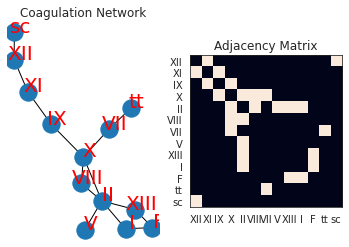

In [0]:
plot_network(CoCa) #plot our network to see what it looks like

There's a *lot* going on in the coagulation cascade.
Let's assume we don't know the coagulation cascade ahead of time and that we want to find things out about it through measurements.
In this notebook we'll focus on finding out which factors contribute to the PTT and in what relative 'proportions'.

**Note: For the sake of example, we have zerod out the 'common pathway' in the PTT calculation. This is done solely to set up a system that is 'sparse' and doesn't include a lot of factors**

### Aside: The Experimental Approach
How we would go about designing a set of experiments to *find out* the link between everything?

In a standard approach, we'd find a lab so that we can keep a very carefully controlled environment.
We'd then keep all but two of the variables constant, change one (independent variable), and see if the other one changes (dependent variable).
Because our measurements are never perfect, we would do a power analysis to find out how many times we'd have to do this experiment to be able to reliably say if two factors are/aren't related.

Since there are ~10 factors there, we'd need 10 * 9 = 90 experiments for this.
In each experiment we'd need more than one trial, the exact number depends on how good our measurements are.
Let's be generous and say they're decent, so we only need 5 trials for each experiment.
That leaves us 450 experiments to figure out the structure of the network above.

Or, we could turn to ML.


### Generative Model vs Regression Model (Mathy)

We know the PT ($y$ below) involves certain factors $X_i$ where each factor contributs a certain amount $c_i$.

$y = c_1 \cdot X_1 + c_2 \cdot X_2 + c_3 \cdot X_3 + c_4 \cdot X_4 + c_5 \cdot X_5 + c_6 \cdot X_6 + c_7 \cdot X_7 + c_8 \cdot X_8 + c_9 \cdot X_9 + c_{10} \cdot X_{10} + c_{11} \cdot X_{11} + c_{12} \cdot X_{12} + c_{13} \cdot X_{13}$

But we know that not every factor directly contributes to the PTT, so a lot of the coefficients $c_i$ are actually equal to zero!

$y = c_1 \cdot X_1 + c_2 \cdot X_2 + c_3 \cdot X_3 + c_4 \cdot X_4 + c_5 \cdot X_5 + c_6 \cdot X_6 + c_7 \cdot X_7 + c_8 \cdot X_8 + c_9 \cdot X_9 + c_{10} \cdot X_{10} + c_{11} \cdot X_{11} + c_{12} \cdot X_{12} + c_{13} \cdot X_{13}$

In a much more simplified form, this is what we know the *truth* is:

$y = c_1 \cdot X_1 + c_2 \cdot X_2 + c_3 \cdot X_3 + c_6 \cdot X_6 + c_{10} \cdot X_{10}$

And we know that our measurements are never perfect and that there's *noise*.
Think of noise as 10 of your friends checking their phone to see what the temperature outside in Atlanta is and getting ~5 different numbers -> you know there's only a single number but measurements come with a little 'jitter'.


**So the equation that will be *generating* our data:**
$\text{PTT} = 3 \times \text{XII} + 2.4 \times \text{XI} - 2.0 \times \text{IX} + 3.4 \times \text{VIII} - 2.0 \times \text{I}$

Our goal is to figure out what this equation is knowing only the concentration of factors and the PTT value, and *not* knowing the specific numbers .
That's what the regression will help us find.

## Standard Linear Regression

So we got our (simulated) data from 10 patients.
We have 13 Factor and 1 PTT measurement for each patient.
We want to find a way to figure out how each factor contributes to the PTT.

First, we're going to do a standard linear regression to try to find out (a) 

*   List item
*   List item

which factors contribute to the PTT and (b) *how much* each factor contributes to the PTT.

In [0]:
#generate our patient data
#Here, we're only including 10 patients, but we have 13 variables that we're trying to study. Would normally be a problem!
X,y = gen_data(pt_len=10)

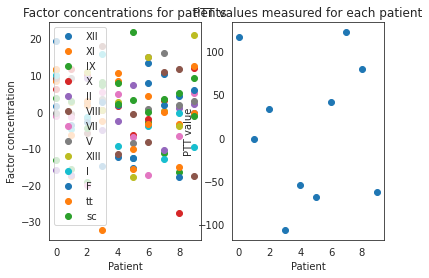

In [0]:
plot_raw_data(X,y,CoCa)

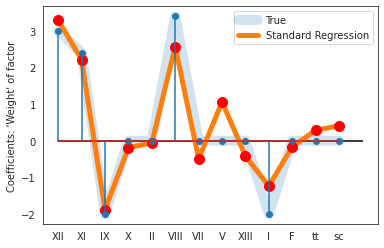

In [0]:
# Setup our regression model using LinearRegression() from scikit-learn
reg = sklearn.linear_model.LinearRegression(fit_intercept=True).fit(X.T,y)

plot_models([reg],labels=['Standard Regression'])

The linear regression approach looks decent, but it does something that we know can't be true: it thinks pretty much *every* factor contributes to the PTT.
There are some coefficients in the model that are small, but still non-zero (See factor X, VII) and there are some that are included but way off (Factor V, tt, sc).

One reason for this is that we have only 10 patients with 13 variables; this is like trying to fit a line to a single point on a plane, or a plane to just two points in 3d space.

The standard solution here would be to go collect samples from more patients so that we have enough to fit 13 variables *and* overcome the noise that is in our data.

## REGULARIZED Linear Regression to the rescue!

Now we start getting into some real ML.
One thing we can do is "inject" a little bit of knowledge into our linear regression: we can discourage the algorithm from including factors unless it's **really really** useful to include them.
This can be done with what is called 'regularization'.

This is a rigorous way that we can tell the algorithm to "look for models that have this specific property that we're pretty sure the real model would have".

One of the most important pieces of this is the "alpha" parameter we send into the lasso: this tells us how much we're "discouraing" the algorithm from letting coefficients be not-zero.

In [0]:
lwid = interactive(run_lasso,alpha=(0.01,100.0,0.01))
display(lwid)
#Get our modified regression model from inside the widget

interactive(children=(FloatSlider(value=0.01, description='alpha', min=0.01, step=0.01), Output()), _dom_class…

Now, as an exercise for *you*, go back to the code and change the alpha range to go from 0.01-1.0 to 0.01,100.0.
Then see what the slider does as you increase the alpha and "really, really discourage" the model from having non-zero coefficients!

## Replicating our findings

Ok, so we found a pattern in the data we had.
One of the (very correct) warnings that we're taught when analysing data is: you'll *always* find patterns, doesn't mean they're really there.
One way to be sure a pattern is there is to *collect a lot of data* and then look for simple patterns [null-hypothesis testing]().

Another approach is to take the results from a previous study and see if you can reproduce them.
This is considered a 'gold standard' in biomedical research (though there are reasons we should reconsider this [paper](https://www.biorxiv.org/content/10.1101/2020.04.26.048306v1)).

Let's do that here.
Let's take the model we learned above and 'replicate' the results in a new dataset.

**WARNING: this code runs off of the GREEN model you learned *above*. Meaning, if you're trying to see how improved Lasso is over the standard Linear Regression, go back up and set the alpha to ~2.0**

### 100 new patients!

You're lucky!
One year has gone by and more people realize your research is important.
The next experiment was able to recruit 100 patients, which is a lot more than we had when we were *learning* the pattern.

So we've got 100 new patients and we want to predict their PTT from just their factor concentrations.
This new experiment will let us see how well our models holds in the larger population.
We've got two models that we generated from our "study" above, let's see how each of them performs in accurately predicting the PTT in these next 100 patients.

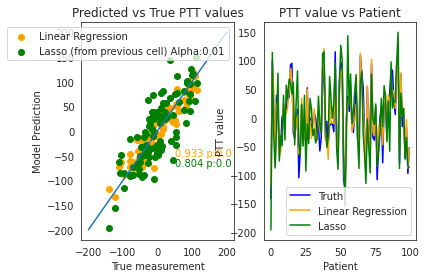

In [0]:
#This saves the model that came out of the widget into a variable so we can use it
mod_reg = lwid.result
lasso_alpha = lwid.children[0].value

#Make our testing set data
X_test,y_test = gen_data(pt_len=100)

#Set up our predictions from each of the linear regression models we learned above
y_pred_standard = reg.predict(X_test.T)
y_pred_lasso = mod_reg.predict(X_test.T)

plot_replication(y_test,y_pred_standard,y_pred_lasso)

# Closing Remarks

In this notebook we ran through a relatively simple multidimensional regression problem based on the coagulation cascade.
First we visualized our network to make a simulated dataset.
Then we 'forgot' that we made the dataset and tried to use linear regression to learn the way different factors related to the PTT.

We found that *regularized* regression let us use 'extra information' (or priors) to account for small sample size and noise.
We may not have had much patients but, with the help of regularization, we were able to learn a model that was capable of pretty good prediction in a replication study!

What this lets us do as scientists is make the most of the data we have available right now and then *update* our results as new data streams in.
This approach is a lot more congruent with how physicians have always worked and may help make Discovery more streamlined and productive!\

Copyright 2020 MedML